## Condo Prices Prediction in Toronto

### The Toronto condo market has been heated in the past few years with the economy recovering, and open immigration policies leading to overall population growth. 

### This project aims to predict listing unit prices of condo units in Toronto based on their individual characteristics. Different features were derived from raw data, and various models were evaluated in order to attain best accuracy. 

![Housing_Image](./TOhousingimage.jpeg)

#### Data were previously collected. Listings were mainly from 2018.

### Read in data

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')
# Override some default panda options to make it easy to display data
# pd.set_option('display.max_colwidth', -1)
# pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)

In [3]:
# Read csv data into a pandas dataframe
column_name = ['id', 'link', 'name', 'size_range','listing_price', 'price_per_ft2', 'bed', 'shower', 'parking', 'dom', 'maint_fee', 'region', 'street', 'unit_num', 'latitude','longitude', 'locker', 'taxes', 'exposure', 'balcony', 'description','pics','floorplans']

df = pd.read_csv('aug8_soups.csv', delimiter = '|',header = None, names = column_name)

In [4]:
df.head(5)

,id,link,name,size_range,listing_price,price_per_ft2,bed,shower,parking,dom,maint_fee,region,street,unit_num,latitude,longitude,locker,taxes,exposure,balcony,description,pics,floorplans
0,C4213966,https://condos.ca/toronto/studio-2-30-nelson-s...,"Studio 2, #1004",700-799,"$798,000","$1,047",2,2,Yes,0,$480,CA-ON,30 Nelson St,1004,43.649100,-79.38840,No,"$3,109",Se,Open,"Quality Built Studio 2 Condo By Aspen Ridge,Br...",['https://condos.ca/public/condo_listing/91/4b...,NaN
1,E4213970,https://condos.ca/toronto/guildwood-terrace-32...,"Guildwood Terrace, #802",1000-1199,"$399,000",$337,2+1,2,Yes,0,$920,CA-ON,3231-3233 Eglinton Ave E,802,43.744281,-79.21371,Exclusive,"$1,394",E,None,Spacious & Bright 1200 Sqft. Corner Unit With ...,['https://condos.ca/public/condo_listing/fa/4c...,NaN
2,W4213969,https://condos.ca/toronto/the-2800-condos-2800...,The 2800 Condos,900-999,"$573,800",$N/A,2+1,2,No,0,$0,CA-ON,2800 Keele St,807,43.728700,-79.48280,No,Unknown,Nw,Open,Please Log in to seeBroker: DANMAR EMPIRE REAL...,['https://condos.ca//public/condo_building/f0/...,NaN
3,W4213978,https://condos.ca/toronto/palace-place-1-palac...,"Palace Place, #4011",1000-1199,"$589,000",$N/A,1,2,Yes,0,$996,CA-ON,1 Palace Pier Crt,4011,43.631400,-79.47250,Owned,"$2,686",Ne,None,Palace Place! Largest 1 Bedroom Suite In The B...,['https://condos.ca/public/condo_listing/1e/4e...,NaN
4,C4212803,https://condos.ca/toronto/the-mansions-on-jarv...,The Mansions on Jarvis,500-599,"$439,000",$784,1,1,No,0,$217,CA-ON,539 Jarvis St,GT3,43.667600,-79.37880,Owned,"$2,119",S,Juliette,Please Log in to seeBroker: ROYAL LEPAGE REAL ...,['https://condos.ca//public/condo_building/0c/...,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2159 entries, 0 to 2158
Data columns (total 23 columns):
id               2159 non-null object
link             2159 non-null object
name             2159 non-null object
size_range       2159 non-null object
listing_price    2159 non-null object
price_per_ft2    1926 non-null object
bed              2157 non-null object
shower           2159 non-null int64
parking          2159 non-null object
dom              2159 non-null int64
maint_fee        2159 non-null object
region           2159 non-null object
street           2107 non-null object
unit_num         2156 non-null object
latitude         2159 non-null float64
longitude        2159 non-null float64
locker           2159 non-null object
taxes            2159 non-null object
exposure         2157 non-null object
balcony          2159 non-null object
description      2159 non-null object
pics             2159 non-null object
floorplans       1 non-null object
dtypes: float64(2), in

In [6]:
df.describe()

,shower,dom,latitude,longitude
count,2159.000000,2159.000000,2159.000000,2159.000000
mean,1.616489,49.167670,43.707152,-79.397517
std,0.673355,100.772841,0.062603,0.079238
min,1.000000,0.000000,43.587655,-79.615900
25%,1.000000,7.000000,43.645500,-79.430300
50%,2.000000,31.000000,43.701300,-79.395200
75%,2.000000,62.000000,43.769813,-79.365900
max,16.000000,961.000000,43.826300,-79.169400


#### As we can see, there are a total of 23 columns, and 4 of them contains numerical data, the rest are either categorical or need to be transformed. 

#### First, we split the name column as it contains crucial information of the unit number, from which we can derive the floor number

In [7]:
df_split_name = df['name'].str.split(',', expand= True).rename(columns={0:'Condo_name', 1:'suite_num'})
df_split_name = df_split_name.drop([2,3], 1)

In [8]:
df_concat = pd.concat([df, df_split_name], axis= 1)

In [9]:
import re


def process_floor_num(df):
    """This function cleans the room numbers and applies rules to retrieve floor numbers, typically first one or
    two digits of the room number. """
    floor_ls = []
    unit_ls = []
    for room in df['unit_num']:
        floor = 9999
        unit = 9999

        if room and room != ' ' and not str(room) == 'nan':

            clean_room = room.strip('#').strip()

            if clean_room.isdigit():
                if len(clean_room) ==1:
                    floor = 1
                    unit = clean_room
                    floor_ls.append(floor)
                    unit_ls.append(unit) 

                elif len(clean_room) ==2:
                    floor = 1
                    unit = clean_room
                    floor_ls.append(floor)
                    unit_ls.append(unit) 

                elif len(clean_room) ==3:
                    floor = clean_room[0]
                    unit = clean_room[1:]
                    floor_ls.append(floor)
                    unit_ls.append(unit)

                elif len(clean_room) ==4:
                    floor = clean_room[:2]
                    unit = clean_room[2:]
                    floor_ls.append(floor)
                    unit_ls.append(unit)

                else:
                    print('check digits!')
                    floor_ls.append(floor)
                    unit_ls.append(unit)

            elif not clean_room.isdigit() and re.match('(?i)[a-z]\d{2}', clean_room.lower()):
                floor = 1
                unit = clean_room[1:]
                floor_ls.append(floor)
                unit_ls.append(unit)

            elif not clean_room.isdigit() and re.match('(?i)[a-z]\d{2}', clean_room.lower()):
                floor = clean_room[1]
                unit = clean_room[2:]
                floor_ls.append(floor)
                unit_ls.append(unit)

            elif not clean_room.isdigit() and re.match('\d{4}\w$', clean_room.lower()):
                floor = clean_room[:2]
                unit = clean_room[2:4]
                floor_ls.append(floor)
                unit_ls.append(unit)

            elif not clean_room.isdigit() and re.match('\d{3}\w$', clean_room.lower()):
                floor = clean_room[0]
                unit = clean_room[1:3]
                floor_ls.append(floor)
                unit_ls.append(unit)

            elif not clean_room.isdigit() and 'th' in clean_room.lower():
                floor = 1
                unit = clean_room.lower().strip('th').strip('-').strip()
                floor_ls.append(floor)
                unit_ls.append(unit)

            elif not clean_room.isdigit() and 'gt' in clean_room.lower():
                floor = 1
                unit = clean_room.lower().strip('gt').strip('-').strip()
                floor_ls.append(floor)
                unit_ls.append(unit)            

            elif not clean_room.isdigit() and 'uph' in clean_room.lower(): 
                floor = 'UPH'
                unit = clean_room.lower().strip('uph').strip()
                floor_ls.append(floor)
                unit_ls.append(unit)

            elif not clean_room.isdigit() and 'ph' in clean_room.lower():
                floor = 'PH'
                unit = clean_room.lower().strip('ph').strip()
                floor_ls.append(floor)
                unit_ls.append(unit)

            elif not clean_room.isdigit() and ('lph' in clean_room.lower() or 'lp' in clean_room.lower()):
                floor = 'LPH' 
                unit = clean_room.lower().strip('lph').strip()
                floor_ls.append(floor)
                unit_ls.append(unit)

            else:
                floor_ls = floor_ls
                unit_ls = unit_ls
                floor_ls.append(floor)
                unit_ls.append(unit)

        else:

            floor = 0
            unit = '0000'
            floor_ls.append(floor)
            unit_ls.append(unit)

    return floor_ls, unit_ls

In [10]:
df_concat['floor'], df_concat['room_num']  = process_floor_num(df_concat)

#### Now we read in assciated condo building information, and join them to the unit data in order to get information regarding floors, etc. 

In [11]:
building_column_names = ['Condo_name', 'Building_url', 'Address', 'Pre_constr', 'Neighbourhood', 'Corp#', 'Expected_Completion', 'Developer', 'Number_Units', 'Storeys',
                            'Property_Mgmt_Co', 'Smallest_Suite', 'Largest_Suite', 'Transit_score', 'Description', 'Maint_fee_covers']
df_building = pd.read_csv('20180917_buildings.csv', delimiter = '|',header = None, names = building_column_names)

In [12]:
df_building.head(3)

,Condo_name,Building_url,Address,Pre_constr,Neighbourhood,Corp#,Expected_Completion,Developer,Number_Units,Storeys,Property_Mgmt_Co,Smallest_Suite,Largest_Suite,Transit_score,Description,Maint_fee_covers
0,Wynford Green,https://condos.ca/new-development/wynford-gree...,844 Don Mills Road,Pre-Construction,Banbury | Don Mills,TBD,2020,Context Development,3887,44,Unknown,400.0,1700.0,77,These high-rise Toronto condos are expected to...,"['Common Element Maintenance', 'Building Insur..."
1,The Prestige at Pinnacle Condos,https://condos.ca/new-development/the-prestige...,1 Yonge Street,Pre-Construction,The Waterfront,TBD,2020,Pinnacle International,3885,95,Unknown,600.0,1300.0,100,These high-rise Toronto condos are expected to...,"['Common Element Maintenance', 'Building Insur..."
2,Galleria Mall Condos,https://condos.ca/new-development/galleria-mal...,1245 Dupont Street,Pre-Construction,Dovercourt-Wallace Emerson-Junction,TBD,2020,Freed Developments,3400,47,Unknown,400.0,1200.0,83,Located in the Dovercourt-Wallace Emerson-Junc...,"['Common Element Maintenance', 'Building Insur..."


In [13]:
df_join = pd.merge(df_concat, df_building, how= 'left', on = 'Condo_name')

In [14]:
df_join.head(3)

,id,link,name,size_range,listing_price,price_per_ft2,bed,shower,parking,dom,maint_fee,region,street,unit_num,latitude,longitude,locker,taxes,exposure,balcony,description,pics,floorplans,Condo_name,suite_num,floor,room_num,Building_url,Address,Pre_constr,Neighbourhood,Corp#,Expected_Completion,Developer,Number_Units,Storeys,Property_Mgmt_Co,Smallest_Suite,Largest_Suite,Transit_score,Description,Maint_fee_covers
0,C4213966,https://condos.ca/toronto/studio-2-30-nelson-s...,"Studio 2, #1004",700-799,"$798,000","$1,047",2,2,Yes,0,$480,CA-ON,30 Nelson St,1004,43.649100,-79.38840,No,"$3,109",Se,Open,"Quality Built Studio 2 Condo By Aspen Ridge,Br...",['https://condos.ca/public/condo_listing/91/4b...,NaN,Studio 2,#1004,10,04,https://condos.ca/toronto/studio-2-30-nelson-st,30 Nelson St,NaN,Queen West,TSCC 2573,NaN,Aspen Ridge Homes,411.0,41.0,Icc Property Management,413.0,2573.0,100,From the Builder Studio on Richmond is the qui...,"['Gym / Exercise Room', 'Common Rooftop Deck',..."
1,E4213970,https://condos.ca/toronto/guildwood-terrace-32...,"Guildwood Terrace, #802",1000-1199,"$399,000",$337,2+1,2,Yes,0,$920,CA-ON,3231-3233 Eglinton Ave E,802,43.744281,-79.21371,Exclusive,"$1,394",E,None,Spacious & Bright 1200 Sqft. Corner Unit With ...,['https://condos.ca/public/condo_listing/fa/4c...,NaN,Guildwood Terrace,#802,8,02,https://condos.ca/toronto/guildwood-terrace-32...,3231-3233 Eglinton Ave E,NaN,Scarborough Village,MTCC 1013,NaN,Tridel,349.0,20.0,Gpm Property Management,690.0,1463.0,67,Located at 3231-3233 Eglinton Avenue East in S...,"['Gym / Exercise Room', 'Pool', 'Parking Garag..."
2,W4213969,https://condos.ca/toronto/the-2800-condos-2800...,The 2800 Condos,900-999,"$573,800",$N/A,2+1,2,No,0,$0,CA-ON,2800 Keele St,807,43.728700,-79.48280,No,Unknown,Nw,Open,Please Log in to seeBroker: DANMAR EMPIRE REAL...,['https://condos.ca//public/condo_building/f0/...,NaN,The 2800 Condos,None,8,07,https://condos.ca/toronto/the-2800-condos-2800...,2800 Keele St,NaN,Downsview | Roding | CFB,TSCC 2637,NaN,QuadCam Development Group,214.0,11.0,Unknown,309.0,1446.0,69,Located in the Downsview-Roding-CFB neighbourh...,"['Gym / Exercise Room', 'Common Rooftop Deck',..."


### Encode categorical data

In [15]:
def encode_cat(df, cat_feature_list):
    for feature in cat_feature_list:
        if feature == 'exposure':
            df[feature] = df[feature].str.lower()
        df = pd.concat([df,pd.get_dummies(df[feature], prefix=feature)],axis=1)
        df.drop([feature],axis=1, inplace=True)
    return df

In [16]:
cat_feature_list = ['balcony', 'bed', 'locker', 'exposure', 'Neighbourhood',
                   'Developer', 'Condo_name', 'Property_Mgmt_Co']
encoded_df = encode_cat(df_join, cat_feature_list)

In [17]:
# For parking, user binarizer to encode as it should be a boolean value
binarizer_prk = preprocessing.LabelBinarizer(sparse_output=False)
encoded_df['parking'] = binarizer_prk.fit_transform(encoded_df['parking'])

In [18]:
encoded_df.head(3)

,id,link,name,size_range,listing_price,price_per_ft2,shower,parking,dom,maint_fee,region,street,unit_num,latitude,longitude,taxes,description,pics,floorplans,suite_num,floor,room_num,Building_url,Address,Pre_constr,Corp#,Expected_Completion,Number_Units,Storeys,Smallest_Suite,Largest_Suite,Transit_score,Description,Maint_fee_covers,balcony_Enclosed,balcony_Juliette,balcony_None,balcony_Open,balcony_Terrace,balcony_Unknown,bed_1,bed_1+1,bed_2,bed_2+1,bed_3,bed_3+1,bed_4,bed_4+1,bed_Studio,bed_Studio & 1,locker_Common,locker_Ensuite,locker_Ensuite-Owned,locker_Exclusive,locker_No,locker_Owned,exposure_e,exposure_ew,exposure_n,exposure_ne,exposure_ns,exposure_nw,exposure_s,exposure_se,exposure_sw,exposure_w,Neighbourhood_Agincourt North,Neighbourhood_Agincourt South-Malvern West,Neighbourhood_Alderwood,Neighbourhood_Annex | U of T,Neighbourhood_Banbury | Don Mills,Neighbourhood_Bathurst Manor,Neighbourhood_Bay St. Corridor,Neighbourhood_Bayview Village,Neighbourhood_Bayview Woods-Steeles,Neighbourhood_Bedford Park-Nortown,Neighbourhood_Beechborough-Greenbrook,Neighbourhood_Bendale,Neighbourhood_Birchcliffe-Cliffside,Neighbourhood_Black Creek,Neighbourhood_Briar Hill-Belgravia,Neighbourhood_Bridle Path | Sunnybrook | York Mills,Neighbourhood_Broadview North,Neighbourhood_Brookhaven-Amesbury,Neighbourhood_Cabbagetown,Neighbourhood_Casa Loma,Neighbourhood_Church St. Corridor,Neighbourhood_CityPlace,Neighbourhood_Clairlea | Birchmount,Neighbourhood_Clanton Park,Neighbourhood_Cliffcrest,Neighbourhood_Corktown,Neighbourhood_Distillery District,Neighbourhood_Don Valley Village,Neighbourhood_Dorset Park,Neighbourhood_Dovercourt-Wallace Emerson-Junction,Neighbourhood_Downsview | Roding | CFB,Neighbourhood_East End-Danforth,Neighbourhood_Edenbridge | Humber Valley,Neighbourhood_Eglinton East,Neighbourhood_Englemount | Lawrence,Neighbourhood_Eringate | Centennial | West Deane,Neighbourhood_Etobicoke West Mall,Neighbourhood_Flemingdon Park,Neighbourhood_Forest Hill North,Neighbourhood_Forest Hill South,Neighbourhood_Fort York,Neighbourhood_Grange Park,Neighbourhood_Guildwood,Neighbourhood_Henry Farm,Neighbourhood_High Park North,Neighbourhood_High Park-Swansea,Neighbourhood_Hillcrest Village,Neighbourhood_Humber Heights | Westmount,Neighbourhood_Humber Summit,Neighbourhood_Humbermede,Neighbourhood_Humewood-Cedarvale,Neighbourhood_Islington | City Centre West,Neighbourhood_Junction Area,Neighbourhood_Keelesdale-Eglinton West,Neighbourhood_Kennedy Park,Neighbourhood_Kensington Market,Neighbourhood_King West,Neighbourhood_Kingsview Village | The Westway,Neighbourhood_L'Amoreaux,Neighbourhood_Lansing-Westgate,Neighbourhood_Lawrence Park North,Neighbourhood_Lawrence Park South,Neighbourhood_Leaside,Neighbourhood_Liberty Village,Neighbourhood_Little Italy,Neighbourhood_Little Portugal,Neighbourhood_Long Branch,Neighbourhood_Malvern,Neighbourhood_Markland Wood,Neighbourhood_Milliken,Neighbourhood_Mimico,Neighbourhood_Morningside,Neighbourhood_Moss Park,Neighbourhood_Mount Dennis,Neighbourhood_Mount Olive | Silverstone | Jamestown,Neighbourhood_Mount Pleasant East,Neighbourhood_Mount Pleasant West,Neighbourhood_Newtonbrook East,Neighbourhood_Newtonbrook West,Neighbourhood_O'Connor-Parkview,Neighbourhood_Oakridge,Neighbourhood_Parkwoods-Donalda,Neighbourhood_Pleasant View,Neighbourhood_Queen West,Neighbourhood_Regent Park,Neighbourhood_Rockcliffe-Smythe,Neighbourhood_Roncesvalles,Neighbourhood_Rosedale-Moore Park,Neighbourhood_Rouge E11,Neighbourhood_Scarborough Village,Neighbourhood_South Parkdale,Neighbourhood_South Riverdale | Leslieville,Neighbourhood_St. Andrew | Windfields,Neighbourhood_St. James Town,Neighbourhood_St. Lawrence,Neighbourhood_Steeles,Neighbourhood_Stonegate-Queensway,Neighbourhood_Tam O'Shanter | Sullivan,Neighbourhood_The Beaches,Neighbourhood_The Core,Neighbourhood_The Waterfront,Neighbourhood_Thorncliffe Park,Neighbourhood_Victoria Village,Neighbourhood_West Hill,Neighbourhood_West Humber | Clairville,Neighbourhood_Westminste

In [19]:
# convert main_fee col to int
encoded_df['maint_fee'] = [int(x.strip('$').replace(",", "")) if type(x)==str else x for x in encoded_df['maint_fee']]

In [20]:
# convert tax col to int
encoded_df['taxes'] = tax_arry = [int(x.strip('$').replace(",", "")) if type(x)==str and x != 'Unknown' else np.NaN for x in encoded_df['taxes']]

### Deal with missing values

In [21]:
encoded_df['taxes'] = encoded_df['taxes'].fillna(value = encoded_df['taxes'].mean())

### Deal with floor numbers

In [22]:
#calculate floor ratio (floor the room is at / total floors in building)
encoded_df['floor_ratio'] = encoded_df[~encoded_df['floor'].isin(['UPH', 'LPH','PH', 9999])]['floor'].astype('int') / \
encoded_df[~encoded_df['floor'].isin(['UPH', 'LPH','PH', 9999])]['Storeys']

In [23]:
# Handle lower penthouse case
floor_index = encoded_df.columns.get_loc("floor")
encoded_df.iloc[[encoded_df[encoded_df['floor'].str.lower() == 'lph'].index], floor_index] = (encoded_df[encoded_df['floor'].str.lower() == 'lph']['Storeys'] - 1) / \
encoded_df[encoded_df['floor'].str.lower() == 'lph']['Storeys']

In [24]:
# Handle penthouse
top_fl = encoded_df.loc[encoded_df['floor'].str.lower().isin(['ph', 'uph'])]['Storeys']
floor_ratio = top_fl.fillna(1.0) / top_fl.fillna(1.0)

In [25]:
# ph and uph calculation 
encoded_df.iloc[floor_ratio.index, floor_index] = floor_ratio.values

In [26]:
encoded_df.head(3)

,id,link,name,size_range,listing_price,price_per_ft2,shower,parking,dom,maint_fee,region,street,unit_num,latitude,longitude,taxes,description,pics,floorplans,suite_num,floor,room_num,Building_url,Address,Pre_constr,Corp#,Expected_Completion,Number_Units,Storeys,Smallest_Suite,Largest_Suite,Transit_score,Description,Maint_fee_covers,balcony_Enclosed,balcony_Juliette,balcony_None,balcony_Open,balcony_Terrace,balcony_Unknown,bed_1,bed_1+1,bed_2,bed_2+1,bed_3,bed_3+1,bed_4,bed_4+1,bed_Studio,bed_Studio & 1,locker_Common,locker_Ensuite,locker_Ensuite-Owned,locker_Exclusive,locker_No,locker_Owned,exposure_e,exposure_ew,exposure_n,exposure_ne,exposure_ns,exposure_nw,exposure_s,exposure_se,exposure_sw,exposure_w,Neighbourhood_Agincourt North,Neighbourhood_Agincourt South-Malvern West,Neighbourhood_Alderwood,Neighbourhood_Annex | U of T,Neighbourhood_Banbury | Don Mills,Neighbourhood_Bathurst Manor,Neighbourhood_Bay St. Corridor,Neighbourhood_Bayview Village,Neighbourhood_Bayview Woods-Steeles,Neighbourhood_Bedford Park-Nortown,Neighbourhood_Beechborough-Greenbrook,Neighbourhood_Bendale,Neighbourhood_Birchcliffe-Cliffside,Neighbourhood_Black Creek,Neighbourhood_Briar Hill-Belgravia,Neighbourhood_Bridle Path | Sunnybrook | York Mills,Neighbourhood_Broadview North,Neighbourhood_Brookhaven-Amesbury,Neighbourhood_Cabbagetown,Neighbourhood_Casa Loma,Neighbourhood_Church St. Corridor,Neighbourhood_CityPlace,Neighbourhood_Clairlea | Birchmount,Neighbourhood_Clanton Park,Neighbourhood_Cliffcrest,Neighbourhood_Corktown,Neighbourhood_Distillery District,Neighbourhood_Don Valley Village,Neighbourhood_Dorset Park,Neighbourhood_Dovercourt-Wallace Emerson-Junction,Neighbourhood_Downsview | Roding | CFB,Neighbourhood_East End-Danforth,Neighbourhood_Edenbridge | Humber Valley,Neighbourhood_Eglinton East,Neighbourhood_Englemount | Lawrence,Neighbourhood_Eringate | Centennial | West Deane,Neighbourhood_Etobicoke West Mall,Neighbourhood_Flemingdon Park,Neighbourhood_Forest Hill North,Neighbourhood_Forest Hill South,Neighbourhood_Fort York,Neighbourhood_Grange Park,Neighbourhood_Guildwood,Neighbourhood_Henry Farm,Neighbourhood_High Park North,Neighbourhood_High Park-Swansea,Neighbourhood_Hillcrest Village,Neighbourhood_Humber Heights | Westmount,Neighbourhood_Humber Summit,Neighbourhood_Humbermede,Neighbourhood_Humewood-Cedarvale,Neighbourhood_Islington | City Centre West,Neighbourhood_Junction Area,Neighbourhood_Keelesdale-Eglinton West,Neighbourhood_Kennedy Park,Neighbourhood_Kensington Market,Neighbourhood_King West,Neighbourhood_Kingsview Village | The Westway,Neighbourhood_L'Amoreaux,Neighbourhood_Lansing-Westgate,Neighbourhood_Lawrence Park North,Neighbourhood_Lawrence Park South,Neighbourhood_Leaside,Neighbourhood_Liberty Village,Neighbourhood_Little Italy,Neighbourhood_Little Portugal,Neighbourhood_Long Branch,Neighbourhood_Malvern,Neighbourhood_Markland Wood,Neighbourhood_Milliken,Neighbourhood_Mimico,Neighbourhood_Morningside,Neighbourhood_Moss Park,Neighbourhood_Mount Dennis,Neighbourhood_Mount Olive | Silverstone | Jamestown,Neighbourhood_Mount Pleasant East,Neighbourhood_Mount Pleasant West,Neighbourhood_Newtonbrook East,Neighbourhood_Newtonbrook West,Neighbourhood_O'Connor-Parkview,Neighbourhood_Oakridge,Neighbourhood_Parkwoods-Donalda,Neighbourhood_Pleasant View,Neighbourhood_Queen West,Neighbourhood_Regent Park,Neighbourhood_Rockcliffe-Smythe,Neighbourhood_Roncesvalles,Neighbourhood_Rosedale-Moore Park,Neighbourhood_Rouge E11,Neighbourhood_Scarborough Village,Neighbourhood_South Parkdale,Neighbourhood_South Riverdale | Leslieville,Neighbourhood_St. Andrew | Windfields,Neighbourhood_St. James Town,Neighbourhood_St. Lawrence,Neighbourhood_Steeles,Neighbourhood_Stonegate-Queensway,Neighbourhood_Tam O'Shanter | Sullivan,Neighbourhood_The Beaches,Neighbourhood_The Core,Neighbourhood_The Waterfront,Neighbourhood_Thorncliffe Park,Neighbourhood_Victoria Village,Neighbourhood_West Hill,Neighbourhood_West Humber | Clairville,Neighbourhood_Westminste

#### Encode ordered list of size_range

In [27]:
import collections
le_size = preprocessing.LabelEncoder()
le_size.fit(encoded_df['size_range'])
ordered_size_range = {}
for range_of_size in list(le_size.classes_):
    ordered_size_range[int(range_of_size.split('-')[0])] = range_of_size
ordered_size_range = collections.OrderedDict(sorted(ordered_size_range.items()))

ordered_range_list =[]
for _, ordered_range in ordered_size_range.items():
    ordered_range_list.append(ordered_range)

ordered_range_list.insert(0, '0')
ordered_range_list.insert(4, '700-799')

In [28]:
replace_map_comp = {'size_range' : {k: v for k,v in zip(ordered_range_list,list(range(1,len(ordered_range_list)+1)))}}

In [29]:
df_copy = encoded_df.copy()
df_copy.replace(replace_map_comp, inplace=True)

In [30]:
df_copy['listing_price_int'] = [int(x.strip('$').replace(",", "")) for x in df_copy['listing_price']]

### Clean price per ft2

In [31]:
df_copy['price_per_ft2'] = df_copy['price_per_ft2'].str.replace(',', '')
df_copy['price_per_ft2'] = df_copy['price_per_ft2'].str.replace('$', '')
df_copy['price_per_ft2'] = df_copy['price_per_ft2'].replace({'N/A': np.nan})

In [32]:
df_copy = df_copy[df_copy['price_per_ft2'].notnull()]


In [33]:
df_copy['price_per_ft2'] = df_copy['price_per_ft2'].astype(float) 

In [34]:
df_copy['taxes_per_ft2'] = df_copy['taxes'] / (df_copy['listing_price_int']/df_copy['price_per_ft2'])
df_copy['maint_fee_per_ft2'] = df_copy['maint_fee'] / (df_copy['listing_price_int']/df_copy['price_per_ft2'])

### Distance to Toronto Downtown

No handles with labels found to put in legend.


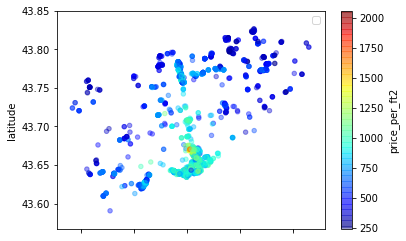

In [35]:
df_copy.plot(kind = 'scatter', x= 'longitude', y= 'latitude', alpha = 0.4,
            c = 'price_per_ft2',
            cmap= plt.get_cmap('jet'), colorbar= True)
plt.legend()


In [36]:
# 82/df_copy['price_per_ft2'].mean()

In [37]:
from math import radians, cos, sin, asin, sqrt
def haversine(lon1, lat1, lon2= -79.3849, lat2= 43.6529):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

In [38]:
df_copy['distance_to_downtown'] = df_copy.apply(lambda row: haversine(row['longitude'], row['latitude']), axis=1)

In [39]:
# This is a list of the columns that are of interst to the model training

X_cols = ['distance_to_downtown','size_range', 
       'shower', 'parking', 'dom','latitude', 'longitude',
        'Storeys',
        'taxes_per_ft2', 
        'Transit_score',
        'maint_fee_per_ft2',
        'balcony_Enclosed',
        'balcony_Juliette',
        'balcony_None',
        'balcony_Open',
        'balcony_Terrace',
        'balcony_Unknown',
        'bed_1',
        'bed_1+1',
        'bed_2',
        'bed_2+1',
        'bed_3',
        'bed_3+1',
        'bed_4',
        'bed_4+1',
        'bed_Studio',
        'bed_Studio & 1',
#         'bed_nan',
        'locker_Common',
        'locker_Ensuite',
        'locker_Ensuite-Owned',
        'locker_Exclusive',
        'locker_No',
        'locker_Owned',
        'exposure_e',
        'exposure_ew',
        'exposure_n',
        'exposure_ne',
        'exposure_ns',
        'exposure_nw',
        'exposure_s',
        'exposure_se',
        'exposure_sw',
        'exposure_w',
        'Neighbourhood_Agincourt North',
        'Neighbourhood_Agincourt South-Malvern West',
        'Neighbourhood_Alderwood',
        'Neighbourhood_Annex | U of T',
        'Neighbourhood_Banbury | Don Mills',
        'Neighbourhood_Bathurst Manor',
        'Neighbourhood_Bay St. Corridor',
        'Neighbourhood_Bayview Village',
        'Neighbourhood_Bayview Woods-Steeles',
        'Neighbourhood_Bedford Park-Nortown',
        'Neighbourhood_Beechborough-Greenbrook',
        'Neighbourhood_Bendale',
        'Neighbourhood_Birchcliffe-Cliffside',
        'Neighbourhood_Black Creek',
        'Neighbourhood_Briar Hill-Belgravia',
        'Neighbourhood_Bridle Path | Sunnybrook | York Mills',
        'Neighbourhood_Broadview North',
        'Neighbourhood_Brookhaven-Amesbury',
        'Neighbourhood_Cabbagetown',
        'Neighbourhood_Casa Loma',
        'Neighbourhood_Church St. Corridor',
        'Neighbourhood_CityPlace',
        'Neighbourhood_Clairlea | Birchmount',
        'Neighbourhood_Clanton Park',
        'Neighbourhood_Cliffcrest',
        'Neighbourhood_Corktown',
        'Neighbourhood_Distillery District',
        'Neighbourhood_Don Valley Village',
        'Neighbourhood_Dorset Park',
        'Neighbourhood_Dovercourt-Wallace Emerson-Junction',
        'Neighbourhood_Downsview | Roding | CFB',
        'Neighbourhood_East End-Danforth',
        'Neighbourhood_Edenbridge | Humber Valley',
        'Neighbourhood_Eglinton East',
        'Neighbourhood_Englemount | Lawrence',
        'Neighbourhood_Eringate | Centennial | West Deane',
        'Neighbourhood_Etobicoke West Mall',
        'Neighbourhood_Flemingdon Park',
        'Neighbourhood_Forest Hill North',
        'Neighbourhood_Forest Hill South',
        'Neighbourhood_Fort York',
        'Neighbourhood_Grange Park',
        'Neighbourhood_Guildwood',
        'Neighbourhood_Henry Farm',
        'Neighbourhood_High Park North',
        'Neighbourhood_High Park-Swansea',
        'Neighbourhood_Hillcrest Village',
        'Neighbourhood_Humber Heights | Westmount',
        'Neighbourhood_Humber Summit',
        'Neighbourhood_Humbermede',
        'Neighbourhood_Humewood-Cedarvale',
        'Neighbourhood_Islington | City Centre West',
        'Neighbourhood_Junction Area',
        'Neighbourhood_Keelesdale-Eglinton West',
        'Neighbourhood_Kennedy Park',
        'Neighbourhood_Kensington Market',
        'Neighbourhood_King West',
        'Neighbourhood_Kingsview Village | The Westway',
        'Neighbourhood_L\'Amoreaux',
        'Neighbourhood_Lansing-Westgate',
        'Neighbourhood_Lawrence Park North',
        'Neighbourhood_Lawrence Park South',
        'Neighbourhood_Leaside',
        'Neighbourhood_Liberty Village',
        'Neighbourhood_Little Italy',
        'Neighbourhood_Little Portugal',
        'Neighbourhood_Long Branch',
        'Neighbourhood_Malvern',
        'Neighbourhood_Markland Wood',
        'Neighbourhood_Milliken',
        'Neighbourhood_Mimico',
        'Neighbourhood_Morningside',
        'Neighbourhood_Moss Park',
        'Neighbourhood_Mount Dennis',
        'Neighbourhood_Mount Olive | Silverstone | Jamestown',
        'Neighbourhood_Mount Pleasant East',
        'Neighbourhood_Mount Pleasant West',
        'Neighbourhood_Newtonbrook East',
        'Neighbourhood_Newtonbrook West',
        'Neighbourhood_O\'Connor-Parkview',
        'Neighbourhood_Oakridge',
        'Neighbourhood_Parkwoods-Donalda',
        'Neighbourhood_Pleasant View',
        'Neighbourhood_Queen West',
        'Neighbourhood_Regent Park',
        'Neighbourhood_Rockcliffe-Smythe',
        'Neighbourhood_Roncesvalles',
        'Neighbourhood_Rosedale-Moore Park',
        'Neighbourhood_Rouge E11',
        'Neighbourhood_Scarborough Village',
        'Neighbourhood_South Parkdale',
        'Neighbourhood_South Riverdale | Leslieville',
        'Neighbourhood_St. Andrew | Windfields',
        'Neighbourhood_St. James Town',
        'Neighbourhood_St. Lawrence',
        'Neighbourhood_Steeles',
        'Neighbourhood_Stonegate-Queensway',
        'Neighbourhood_Tam O\'Shanter | Sullivan',
        'Neighbourhood_The Beaches',
        'Neighbourhood_The Core',
        'Neighbourhood_The Waterfront',
        'Neighbourhood_Thorncliffe Park',
        'Neighbourhood_Victoria Village',
        'Neighbourhood_West Hill',
        'Neighbourhood_West Humber | Clairville',
        'Neighbourhood_Westminster | Branson',
        'Neighbourhood_Weston',
        'Neighbourhood_Wexford-Maryvale',
        'Neighbourhood_Willowdale East',
        'Neighbourhood_Willowdale West',
        'Neighbourhood_Willowridge | Martingrove | Richview',
        'Neighbourhood_Woburn',
        'Neighbourhood_Woodbine Corridor',
        'Neighbourhood_Yonge and Bloor',
        'Neighbourhood_Yonge-Eglinton',
        'Neighbourhood_Yonge-St. Clair',
        'Neighbourhood_York University Heights',
        'Neighbourhood_Yorkdale | Glen Park',
        'Neighbourhood_Yorkville',
        'Developer_1001 Roselawn Avenue Inc',
        'Developer_109 Front Street East Inc.',
        'Developer_123 Eginton Avenue East Inc',
        'Developer_1410839 Ontario Limited',
        'Developer_2 Ridelle Avenue Co-Ownership Inc',
        'Developer_5 St.Joseph Development Ltd',
        'Developer_779857 Ontario Inc.',
        'Developer_Aberfoyle Developments Inc.',
        'Developer_All King Investment Inc',
        'Developer_Alterra & Finner Space Corporation',
        'Developer_Alterra Group',
        'Developer_Amexon Development Corporationn',
        'Developer_Aragon Properties Ltd.',
        'Developer_Arsando Investments Ltd',
        'Developer_Aspen Ridge Homes',
        'Developer_Atrium on Queens Quay Inc.',
        'Developer_B.G. Schickedanz Homes Inc.',
        'Developer_BLVD Developments',
        'Developer_BSaR Group of Companies',
        'Developer_Baghai Development Limited',
        'Developer_Banton Investments Limited',
        'Developer_Barclay-Grayson Group',
        'Developer_Barney River Investments',
        'Developer_Bayview Green Developments Inc.',
        'Developer_Bazis Inc. and Plaza',
        'Developer_Bazis Inc./Metropia/Plaza',
        'Developer_Bazis International',
        'Developer_Beaverbrook Homes',
        'Developer_Beaverhall Homes and Graywood Developments',
        'Developer_Belmont Construction',
        'Developer_Bentley Estates Limited',
        'Developer_Beverhall Homes and Graywood Developments Ltd',
        'Developer_Bomin Construction Ltd',
        'Developer_Bradsil Ltd',
        'Developer_Bramalea Limited',
        'Developer_Bramalea Ltd',
        'Developer_Brandy Lane Homes',
        'Developer_Bransfield Construction Ltd',
        'Developer_Burnac Corporation',
        'Developer_Cadillac Fairview Corporation Limited',
        'Developer_Cam-Nest Developments Limited',
        'Developer_Campeau Corporation',
        'Developer_Camrost Felcorp',
        'Developer_Camrost York Development Corporation',
        'Developer_Camrost York Developments',
        'Developer_Camrost- Felcorp Inc',
        'Developer_Camrost-Felcorp',
        'Developer_CanAlfa',
        'Developer_CanAlfa Group',
        'Developer_Canderel Stoneridge',
        'Developer_Capital Developments',
        'Developer_Castle Group',
        'Developer_Cenpac & Toddglen',
        'Developer_Cenpac Developments',
        'Developer_Centre Town Developments Limited',
        'Developer_CentreCourt Developments Inc.',
        'Developer_Centrecourt',
        'Developer_Century Plaza of Toronto Inc',
        'Developer_Chelsea Gate Inc',
        'Developer_Chesnut Homes',
        'Developer_Chestnut Park Residences Inc',
        'Developer_CityCore Developments & INVAR Building Corp',
        'Developer_Cityscape',
        'Developer_Cityscape Niagara Corp.',
        'Developer_Cityzen Development Corporation',
        'Developer_Cityzen Development Corporation & Myriad Group',
        'Developer_Concord Adex',
        'Developer_Concord Adex Development Corp',
        'Developer_Concord Adex Developments',
        'Developer_Concord Adex Developments Corp.',
        'Developer_Concorde',
        'Developer_Concorde Square Limited',
        'Developer_Conservatory Group',
        'Developer_Context Development',
        'Developer_Context Developments',
        'Developer_Cresford',
        'Developer_Cresford Developments',
        'Developer_Cressford Developments',
        'Developer_Crestford',
        'Developer_Crossroads Apartments Limited',
        'Developer_Curated Properties',
        'Developer_Daniels',
        'Developer_Daniels Corp',
        'Developer_Daniels Corporation',
        'Developer_Davies Smith Developments',
        'Developer_Deltan Realty Ltd',
        'Developer_Devron Developments',
        'Developer_Diamante Development Corporation',
        'Developer_Diamante Developments',
        'Developer_Diamondcorp',
        'Developer_Dogleg Developments Ltd',
        'Developer_Dream Maker Developments Inc',
        'Developer_Dundee Kilmer Developments',
        'Developer_Dundee Kilmer Develpments',
        'Developer_Dundee Realty Corporation',
        'Developer_Dynasty Court Properties Ltd.',
        'Developer_East of Bay Developments Corporation',
        'Developer_Eatons Group of Hotels',
        'Developer_Edilcan',
        'Developer_Edilcan Development',
        'Developer_Elad Canada',
        'Developer_Elm Developments',
        'Developer_Empire',
        'Developer_Empire Communities',
        'Developer_Emporis',
        'Developer_Enderby Developments Limited',
        'Developer_Estobrad Development Corporation',
        'Developer_Evergreen Villa Homes',
        'Developer_FNB Investments Ltd',
        'Developer_Fernbrook Homes',
        'Developer_Fernbrook Homes, Menkes, Cityzen Developments',
        'Developer_Firm Capital Properties Inc',
        'Developer_First Avenue Properties',
        'Developer_First College Grenville Holdings Inc',
        'Developer_Five Kenneth Avenue Ltd',
        'Developer_Forest Green Homes',
        'Developer_Four Wind Fbm Ltd.',
        'Developer_Freed Developments',
        'Developer_Freg Developments Ltd',
        'Developer_Gairloch',
        'Developer_Garden Terrace Developments Inc',
        'Developer_Gemterra Development',
        'Developer_George Wimpey Canada Limited',
        'Developer_George Wimpey Canada Ltd',
        'Developer_Georgian Group',
        'Developer_Ghods Builders Inc',
        'Developer_Ghods Builders Inc.',
        'Developer_Golraf Investments Ltd',
        'Developer_Graydon Hall Estates Limited',
        'Developer_Great Gulf',
        'Developer_Great Gulf Homes',
        'Developer_Great Gulf Homes & Menkes Developments',
        'Developer_Great Gulf Ltd',
        'Developer_Great Land (Kenneth) Residences Inc',
        'Developer_Great Lands Corporation',
        'Developer_Green Park',
        'Developer_Greenland Group',
        'Developer_Greenpark Homes',
        'Developer_Greenrock Alexus Limited',
        'Developer_Greenwin Construction',
        'Developer_Greenwin Ltd',
        'Developer_Greystone Walk Limited',
        'Developer_Greywood Developments',
        'Developer_Grossman Holding Limited',
        'Developer_Grozbord, King & Associates Limited',
        'Developer_H&R; Developments',
        'Developer_H&R; Developments, Lanterra Developments, Lifetime Developments',
        'Developer_Hanson Construction Inc',
        'Developer_Harhay Construction Management Ltd',
        'Developer_Harmony Developments II Inc.',
        'Developer_Harmony Park Properties Inc.',
        'Developer_Harry Stinson',
        'Developer_Hasam Investments Limited',
        'Developer_Heathcliffe Developments Limited',
        'Developer_Helmsbridge Holdings Limited',
        'Developer_Henderson Development',
        'Developer_Huang & Danczkay Ltd',
        'Developer_Huang & Dansky',
        'Developer_Huang and Dansky',
        'Developer_Icon Homes',
        'Developer_Identity Developments Incorporated',
        'Developer_Intracorp',
        'Developer_Intraurban Projects',
        'Developer_Invar Building Corp',
        'Developer_JSC Investments Ltd',
        'Developer_Jason H. Fane',
        'Developer_Jubilation Holdings Inc',
        'Developer_Kantium Developments',
        'Developer_King\'s Terrace on the Humber Limited',
        'Developer_Knightstone Capital Management Inc.',
        'Developer_Kolter Group',
        'Developer_Korank Properties Limited',
        'Developer_Kuhlmax Developments Ltd',
        'Developer_L & A Development (Canada) Ltd',
        'Developer_Lakeview Forest Development Ltd',
        'Developer_Lamb Development Corp',
        'Developer_Lamb Development Corp.',
        'Developer_Landmark & Urbancorp',
        'Developer_Lanet Building Corporation',
        'Developer_Lansino Holdings Limited',
        'Developer_Lanterra',
        'Developer_Lanterra & HR Developments & Malibu Investments',
        'Developer_Lanterra Developemnts, Lifetime Developments',
        'Developer_Lanterra Developments',
        'Developer_Lanterra Developments/ H&R; Developments/ Lifetime Developments',
        'Developer_Lash Developments',
        'Developer_Lawrence Avenue Group Limited',
        'Developer_Leaside Eglinton Holdings Inc.',
        'Developer_Lee Corporate Center Inc',
        'Developer_Lee Corporate Centre Inc',
        'Developer_Lee Development Group',
        'Developer_Liberty Development',
        'Developer_Lifetime Developments',
        'Developer_Lomax',
        'Developer_MOD Developments',
        'Developer_Madison Group',
        'Developer_Madison Homes',
        'Developer_Malibu Investments',
        'Developer_Malibu Investments, The Alterra Group, Urban Capital Property Group, Alit Canada, West Development Group',
        'Developer_Marchant Building Corporation',
        'Developer_Marr Contractors Ltd',
        'Developer_Mastercraft Group',
        'Developer_Mattamy Homes',
        'Developer_May Tower Developments LTD',
        'Developer_Mazel Construction Ltd',
        'Developer_Menkes',
        'Developer_Menkes Development',
        'Developer_Menkes Development Inc',
        'Developer_Menkes Developments',
        'Developer_Menkes Developments Inc',
        'Developer_Menkes Developments Limited',
        'Developer_Merton Development Corporation',
        'Developer_Minto',
        'Developer_Minto Developments',
        'Developer_Minto Group',
        'Developer_Minto Group Inc',
        'Developer_Minto Group Inc.',
        'Developer_Minto Longbranch',
        'Developer_Mizrahi Khalili Developments',
        'Developer_Moksem Corporation',
        'Developer_Mollenhauer Construction',
        'Developer_Monarch',
        'Developer_Monarch Construction',
        'Developer_Monarch Construction Limited',
        'Developer_Monarch Development Corporation',
        'Developer_Monarch Developments',
        'Developer_Monarch Developments Ltd',
        'Developer_Monarch Group',
        'Developer_Monarch Waterview Development Limited',
        'Developer_Montevallo Developments Limited',
        'Developer_Morguard Residential',
        'Developer_Neighbourhood Development Limited',
        'Developer_Neudorfer Corporation',
        'Developer_Norstar Developments',
        'Developer_Norstar Group',
        'Developer_Ogee Holdings Ltd',
        'Developer_Olympia and York Developments',
        'Developer_Olympia and York Developments Ltd',
        'Developer_Onni Group',
        'Developer_Overon Investments Limited',
        'Developer_Parkview-Kingsdale Holdings Limted',
        'Developer_Peel-Elder Developments Limited',
        'Developer_Pemberton Group',
        'Developer_Pemberton Group Inc',
        'Developer_Phantom Developments',
        'Developer_Philmor Group',
        'Developer_Pianosi Development Corp',
        'Developer_Pinnacle International',
        'Developer_Pinnacle International Properties Ltd',
        'Developer_Pivot Investment Limited',
        'Developer_Plaza',
        'Developer_Plaza Corp',
        'Developer_Plus Development Group Corp',
        'Developer_Pointe of View Developments Inc.',
        'Developer_Promary Properties Inc.',
        'Developer_QuadCam Development Group',
        'Developer_Queen Scrop(Dwight)Inc',
        'Developer_RMIC Building Corporation',
        'Developer_Reemark Sterling II Limited',
        'Developer_Remington Group',
        'Developer_Remmington Group',
        'Developer_River Dell Holdings Ltd',
        'Developer_Rocklyn Holding Limited',
        'Developer_Rockport Group',
        'Developer_Roselawn Properties',
        'Developer_Rowdenmoor Investments Limited',
        'Developer_Royal Grand Developments',
        'Developer_Royal Park Homes',
        'Developer_Royal-Dundas Developments Limited',
        'Developer_Rylar Development Ltd',
        'Developer_Rylar Developments',
        'Developer_SRM Development LLC',
        'Developer_Shane Baghai',
        'Developer_Sheppard Point Holding LTD.',
        'Developer_Sherwood Green Homes Limited',
        'Developer_Shiu Pong',
        'Developer_Sorbara Group',
        'Developer_Starwood Group',
        'Developer_State Building Group',
        'Developer_Steeles Hilda Developments Ltd',
        'Developer_Steven & Webster Callahan',
        'Developer_Strasscorp Holdings Inc',
        'Developer_Streetcar Developments',
        'Developer_Sundial Homes',
        'Developer_Sunset Homes',
        'Developer_TWS Developments Inc.',
        'Developer_Tas Design Build',
        'Developer_Tas Designbuild',
        'Developer_The Brown Group',
        'Developer_The Conservatory Group',
        'Developer_The Daniels Group',
        'Developer_The Fountains of Edenbridge Inc.',
        'Developer_The Karleton Company Ltd',
        'Developer_The Pemberton Group',
        'Developer_The Riedel Group',
        'Developer_The Sher Corporation',
        'Developer_The Torchin Group',
        'Developer_The Tradewinds Developments Inc',
        'Developer_Thorncroft Estates Ltd',
        'Developer_Times Group Corp',
        'Developer_Times Group Corporation',
        'Developer_Toddgeln Construction Ltd',
        'Developer_Toddglen Construction, Creson Investments',
        'Developer_Tor-Bel Group',
        'Developer_Torbel Group',
        'Developer_Torbel Group & Urban Fabric Development',
        'Developer_Tower Hill Development Corp.',
        'Developer_Tre Memovia Inc',
        'Developer_Triangle West Developments',
        'Developer_Tribute Communities',
        'Developer_Tridel',
        'Developer_Tridel Corporation',
        'Developer_Triloft Developments',
        'Developer_Triumph Developments',
        'Developer_Tussel Corporation Limited',
        'Developer_United Lands Corporation',
        'Developer_United Lands Corporation Ltd.',
        'Developer_Unknown',
        'Developer_Urban Capital Property Group',
        'Developer_Urban Corp',
        'Developer_Urbancorp',
        'Developer_Urbancorp Development',
        'Developer_V.H.L. Developments Inc.',
        'Developer_V.H.L. Developments Ltd.',
        'Developer_Valentine Developments Limited',
        'Developer_Valfour Developments',
        'Developer_Vandyk',
        'Developer_Victoria & Lawrence (Yorktown) Ltd',
        'Developer_Victoria and Grey Company',
        'Developer_Vienkuhl Construction Ltd',
        'Developer_W.B. Sullivan Construction Limited',
        'Developer_WB Sullivan Construction Ltd',
        'Developer_West Hill Developments',
        'Developer_West Hill Redevelopment Company Limited',
        'Developer_West Hill Redevelopment Company Ltd',
        'Developer_Westclair Developments Inc',
        'Developer_Woodside Pointe Developments',
        'Developer_Worsley Urban Partners',
        'Developer_York Square Developments Inc',
        'Property_Mgmt_Co_360 Community Management',
        'Property_Mgmt_Co_360 Community Management Limited',
        'Property_Mgmt_Co_AA Property Management',
        'Property_Mgmt_Co_APM',
        'Property_Mgmt_Co_Andrejs Management',
        'Property_Mgmt_Co_Atrens Management Group',
        'Property_Mgmt_Co_Aykler Management',
        'Property_Mgmt_Co_Balance Property Management',
        'Property_Mgmt_Co_Berkley Property Management',
        'Property_Mgmt_Co_Briarlane Property Management',
        'Property_Mgmt_Co_Brilliant Property Management',
        'Property_Mgmt_Co_Brookfield Condominium Services',
        'Property_Mgmt_Co_CIE Property Management',
        'Property_Mgmt_Co_Canlight Hall Management',
        'Property_Mgmt_Co_Cape Property Management',
        'Property_Mgmt_Co_Castle Condo Management',
        'Property_Mgmt_Co_City Sites Property Management',
        'Property_Mgmt_Co_Clp Property Management',
        'Property_Mgmt_Co_Comfield Property Management',
        'Property_Mgmt_Co_Comfort Property Management',
        'Property_Mgmt_Co_Condominium Living Management',
        'Property_Mgmt_Co_Connium Management',
        'Property_Mgmt_Co_Cpo/Canadian Properties Operator Management Inc.',
        'Property_Mgmt_Co_Crespro Management',
        'Property_Mgmt_Co_Crossbridge Condominium Services',
        'Property_Mgmt_Co_Daniels Home Management',
        'Property_Mgmt_Co_Daniels Property Management',
        'Property_Mgmt_Co_Del Property Management',
        'Property_Mgmt_Co_Dove Square Management',
        'Property_Mgmt_Co_Dream Maker Property Management',
        'Property_Mgmt_Co_Duka Property Management',
        'Property_Mgmt_Co_Eastway Property Management',
        'Property_Mgmt_Co_Eco Condo Management',
        'Property_Mgmt_Co_Elite Property Management',
        'Property_Mgmt_Co_Equity Ici',
        'Property_Mgmt_Co_First Service Property Management',
        'Property_Mgmt_Co_FirstService Residential',
        'Property_Mgmt_Co_FirstService Residential (Formerly Crosby Property Management)',
        'Property_Mgmt_Co_Gatsby Management',
        'Property_Mgmt_Co_General Property Management',
        'Property_Mgmt_Co_Goldview Property Management',
        'Property_Mgmt_Co_Gpm Property Management',
        'Property_Mgmt_Co_Grenadier Property Management',
        'Property_Mgmt_Co_Gsa Property Management',
        'Property_Mgmt_Co_Harmony Property Management',
        'Property_Mgmt_Co_Horizon Property Management',
        'Property_Mgmt_Co_Icc Property Management',
        'Property_Mgmt_Co_Icon Condomimiums',
        'Property_Mgmt_Co_Icon Property Management',
        'Property_Mgmt_Co_Jtb Management Group Inc',
        'Property_Mgmt_Co_Kindle Property Management',
        'Property_Mgmt_Co_Kipling Realty Management',
        'Property_Mgmt_Co_L & H Property Management',
        'Property_Mgmt_Co_Larlyn Property Management',
        'Property_Mgmt_Co_Lexington Property Management',
        'Property_Mgmt_Co_Living Properties',
        'Property_Mgmt_Co_MF Properties Ltd',
        'Property_Mgmt_Co_Malvern Condominium Property Management',
        'Property_Mgmt_Co_Malvern Property Management',
        'Property_Mgmt_Co_Manor Crest Management Ltd',
        'Property_Mgmt_Co_Manorcrest Management',
        'Property_Mgmt_Co_Maple Ridge Community Management',
        'Property_Mgmt_Co_Maple Ridge Property Management',
        'Property_Mgmt_Co_Mareka Property Management',
        'Property_Mgmt_Co_Menkes Property Management',
        'Property_Mgmt_Co_Menres Property Management',
        'Property_Mgmt_Co_Meritus Group Management Inc',
        'Property_Mgmt_Co_Nadlan-Harris Property Management',
        'Property_Mgmt_Co_Nalan Property Management',
        'Property_Mgmt_Co_Networks Property Management',
        'Property_Mgmt_Co_New City Property Management',
        'Property_Mgmt_Co_Newton-Trelawney',
        'Property_Mgmt_Co_Newton-Trewlany Property Management',
        'Property_Mgmt_Co_Northcan Property Management',
        'Property_Mgmt_Co_Nouvelle Management',
        'Property_Mgmt_Co_Online Property Management',
        'Property_Mgmt_Co_Orion Management',
        'Property_Mgmt_Co_PRO-HOUSE MANAGEMENT LIMITED',
        'Property_Mgmt_Co_Pal/Max Property Management',
        'Property_Mgmt_Co_Percel Professional Management',
        'Property_Mgmt_Co_Percel Property Management',
        'Property_Mgmt_Co_Philmore Group Ltd',
        'Property_Mgmt_Co_Principle Property Management',
        'Property_Mgmt_Co_Pro-House Management Ltd',
        'Property_Mgmt_Co_Prohouse Management',
        'Property_Mgmt_Co_Quadlib',
        'Property_Mgmt_Co_Quadlib Developments',
        'Property_Mgmt_Co_RBA Property Management',
        'Property_Mgmt_Co_Remington Facilities Management',
        'Property_Mgmt_Co_Royal Grand Property Management',
        'Property_Mgmt_Co_Royale Grande Property Management',
        'Property_Mgmt_Co_Self Managed',
        'Property_Mgmt_Co_Shelter Canadian Properties',
        'Property_Mgmt_Co_Shelter Property Management',
        'Property_Mgmt_Co_Shiu Pong Management',
        'Property_Mgmt_Co_Shui Pong Management',
        'Property_Mgmt_Co_Simerra',
        'Property_Mgmt_Co_Simsons Management',
        'Property_Mgmt_Co_Skywater Property Management',
        'Property_Mgmt_Co_St George Property Management',
        'Property_Mgmt_Co_Sterling Property Management',
        'Property_Mgmt_Co_Strategic Property Management',
        'Property_Mgmt_Co_Summerhill Property Management',
        'Property_Mgmt_Co_Taft Forward Property Management',
        'Property_Mgmt_Co_Taylor Property Management',
        'Property_Mgmt_Co_Terrawood Property Management',
        'Property_Mgmt_Co_Times Property Management',
        'Property_Mgmt_Co_Tony Kung & Associates',
        'Property_Mgmt_Co_Tse Management',
        'Property_Mgmt_Co_Unknown',
        'Property_Mgmt_Co_Vero Property Management',
        'Property_Mgmt_Co_Whitehill Residential',
        'Property_Mgmt_Co_Wilson Blanchard',
        'Property_Mgmt_Co_Woroz Management Inc',
        'Property_Mgmt_Co_YL Hendler Ltd.',
        'Property_Mgmt_Co_Zoran Properties',
        'floor_ratio']

In [40]:
df_copy_no_null = df_copy.dropna(subset = ['Storeys', 'Transit_score', 'floor_ratio'])

In [41]:
X = df_copy_no_null[X_cols]
y = df_copy_no_null['price_per_ft2']


In [42]:
X_cols.append('price_per_ft2')
model_input = df_copy_no_null[X_cols]

In [43]:
corr_matrix = model_input.corr()
corr_matrix['price_per_ft2'].sort_values(ascending = False)

price_per_ft2                                         1.000000
Storeys                                               0.486281
Neighbourhood_Bay St. Corridor                        0.296270
bed_1                                                 0.254828
Developer_Lifetime Developments                       0.252501
taxes_per_ft2                                         0.245474
bed_1+1                                               0.217822
Neighbourhood_Yorkville                               0.216630
Neighbourhood_King West                               0.208583
bed_Studio                                            0.204802
Neighbourhood_Yonge and Bloor                         0.192285
maint_fee_per_ft2                                     0.182751
balcony_Open                                          0.177657
Property_Mgmt_Co_Kipling Realty Management            0.175698
Property_Mgmt_Co_FirstService Residential             0.172934
Property_Mgmt_Co_Icon Property Management             0

In [44]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [45]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)
sc_y = StandardScaler()

In [46]:
# Normalizer
normalizer = preprocessing.Normalizer()
X_train = normalizer.fit_transform(X_train)
X_test = normalizer.transform(X_test)

### Start training

In [47]:
#XGBOOST
import xgboost
xgb = xgboost.XGBRegressor(n_estimators=200, learning_rate=0.09, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=6)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.09, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.75)

In [48]:
y_pred_xgb = xgb.predict(X_test)

In [49]:
from sklearn.metrics import mean_squared_error
print(np.sqrt(mean_squared_error(y_test, y_pred_xgb)))

95.23122990824946


In [50]:
# grid search
from sklearn.model_selection import GridSearchCV
import xgboost
from sklearn.metrics import mean_squared_error, make_scorer
# parameters = {'n_estimators' : [150, 200, 250],
#               'learning_rate':[0.01, 0.1],
parameters = {'n_estimators' : [200],
              'min_child_weight': [1, 5, 10],
#               'gamma': [0.5, 1, 1.5, 2.],
#               'subsample': [0.6, 0.8, 1.0],
#               'colsample_bytree': [0.6, 0.8, 1.0],
#               'max_depth': [4, 5, 6, 7]
              }

xgb_cv = xgboost.XGBRegressor(objective='reg:linear')
search = GridSearchCV(xgb_cv, parameters, scoring = 'neg_mean_squared_error', cv = 3, verbose = 4)
search.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] min_child_weight=1, n_estimators=200 ............................
[CV]  min_child_weight=1, n_estimators=200, score=-7114.488072003146, total=   6.6s
[CV] min_child_weight=1, n_estimators=200 ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.6s remaining:    0.0s


[CV]  min_child_weight=1, n_estimators=200, score=-8225.982655306685, total=   6.4s
[CV] min_child_weight=1, n_estimators=200 ............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.0s remaining:    0.0s


[CV]  min_child_weight=1, n_estimators=200, score=-8622.397463378138, total=   6.4s
[CV] min_child_weight=5, n_estimators=200 ............................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   19.4s remaining:    0.0s


[CV]  min_child_weight=5, n_estimators=200, score=-6986.319761869012, total=   6.1s
[CV] min_child_weight=5, n_estimators=200 ............................
[CV]  min_child_weight=5, n_estimators=200, score=-8055.562595576471, total=   8.0s
[CV] min_child_weight=5, n_estimators=200 ............................
[CV]  min_child_weight=5, n_estimators=200, score=-7937.716380493936, total=   7.2s
[CV] min_child_weight=10, n_estimators=200 ...........................
[CV]  min_child_weight=10, n_estimators=200, score=-7003.952553983097, total=   5.9s
[CV] min_child_weight=10, n_estimators=200 ...........................
[CV]  min_child_weight=10, n_estimators=200, score=-8081.409575351351, total=   6.2s
[CV] min_child_weight=10, n_estimators=200 ...........................
[CV]  min_child_weight=10, n_estimators=200, score=-8044.402448921504, total=   7.2s


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.0min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [200], 'min_child_weight': [1, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=4)

In [51]:
search.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=5, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [52]:
search.cv_results_

{'mean_fit_time': array([6.43906919, 7.08562342, 6.44334777]),
 'std_fit_time': array([0.07976248, 0.79167062, 0.52056826]),
 'mean_score_time': array([0.00537809, 0.00658727, 0.01021226]),
 'std_score_time': array([0.0008328 , 0.00138176, 0.00663801]),
 'param_min_child_weight': masked_array(data=[1, 5, 10],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[200, 200, 200],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'min_child_weight': 1, 'n_estimators': 200},
  {'min_child_weight': 5, 'n_estimators': 200},
  {'min_child_weight': 10, 'n_estimators': 200}],
 'split0_test_score': array([-7114.488072  , -6986.31976187, -7003.95255398]),
 'split1_test_score': array([-8225.98265531, -8055.56259558, -8081.40957535]),
 'split2_test_score': array([-8622.39746338, -7937.71638049, -8044.40244892]),
 'mean_test_score': array([-7987.62273023, -7659.8

In [53]:
np.sqrt(3.37055988e+09)/575731.77

0.10083953356908712

### Random forest with feature importance

In [54]:
#Random Forest
from sklearn.ensemble import RandomForestRegressor
rdforest = RandomForestRegressor(max_depth=50, random_state=0,n_estimators=100)
rdforest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [55]:
import pandas as pd
%matplotlib inline

feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X.columns, rdforest.feature_importances_):
    feats[feature] = importance #add the name/value pair 

importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
ordered_importances = importances.sort_values(by='Gini-importance', ascending= False)
# ordered_importances.plot(kind='bar', rot=45)

In [56]:
ordered_importances[:70]

,Gini-importance
taxes_per_ft2,0.757301
distance_to_downtown,0.040956
Transit_score,0.028184
Storeys,0.017444
size_range,0.014062
maint_fee_per_ft2,0.008647
longitude,0.006717
bed_Studio,0.005373
bed_3,0.004537
latitude,0.003978


In [57]:
reduced_features = ordered_importances[:70].index.values

In [58]:
#Reduced Feature
from sklearn.model_selection import train_test_split
X_train_reduced, X_test_reduced, y_train_reduced, y_test_reduced = train_test_split(X[reduced_features], y, test_size = 0.2)

In [59]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train_reduced = sc_X.fit_transform(X_train_reduced)
X_test_reduced = sc_X.transform(X_test_reduced)


In [60]:
#XGBOOST
import xgboost
xgb = xgboost.XGBRegressor(n_estimators=200, learning_rate=0.09, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=6)
xgb.fit(X_train_reduced, y_train_reduced)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.09, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.75)

In [61]:
y_pred_xgb_reduced = xgb.predict(X_test_reduced)

In [62]:
from sklearn.metrics import mean_squared_error
print(np.sqrt(mean_squared_error(y_test_reduced, y_pred_xgb_reduced)))

76.98478642379703


In [63]:
# Reduced features for XGBoost
# grid search
from sklearn.model_selection import GridSearchCV
import xgboost
from sklearn.metrics import mean_squared_error, make_scorer


# X_train_pca = pca.fit_transform(X_train)
# X_test_pca = pca.transform(X_test)
# parameters = {'n_estimators' : [150, 200, 250],
#               'learning_rate':[0.01, 0.1],
parameters = {'n_estimators' : [200],
              'min_child_weight': [1, 5, 10]
              }


xgb_cv = xgboost.XGBRegressor()
search3 = GridSearchCV(xgb_cv, parameters, cv = 10, verbose = 4, scoring = 'neg_mean_squared_error')
search3.fit(X_train_reduced, y_train_reduced)  

Fitting 10 folds for each of 3 candidates, totalling 30 fits
[CV] min_child_weight=1, n_estimators=200 ............................
[CV]  min_child_weight=1, n_estimators=200, score=-6061.88929285325, total=   0.4s
[CV] min_child_weight=1, n_estimators=200 ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  min_child_weight=1, n_estimators=200, score=-5587.194632654078, total=   0.4s
[CV] min_child_weight=1, n_estimators=200 ............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s


[CV]  min_child_weight=1, n_estimators=200, score=-5950.223610669075, total=   0.4s
[CV] min_child_weight=1, n_estimators=200 ............................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.3s remaining:    0.0s


[CV]  min_child_weight=1, n_estimators=200, score=-5336.423982216706, total=   0.4s
[CV] min_child_weight=1, n_estimators=200 ............................
[CV]  min_child_weight=1, n_estimators=200, score=-5014.425163210362, total=   0.4s
[CV] min_child_weight=1, n_estimators=200 ............................
[CV]  min_child_weight=1, n_estimators=200, score=-5594.878667750632, total=   0.4s
[CV] min_child_weight=1, n_estimators=200 ............................
[CV]  min_child_weight=1, n_estimators=200, score=-10668.441541707629, total=   0.4s
[CV] min_child_weight=1, n_estimators=200 ............................
[CV]  min_child_weight=1, n_estimators=200, score=-5490.074905747909, total=   0.4s
[CV] min_child_weight=1, n_estimators=200 ............................
[CV]  min_child_weight=1, n_estimators=200, score=-5785.679437559626, total=   0.4s
[CV] min_child_weight=1, n_estimators=200 ............................
[CV]  min_child_weight=1, n_estimators=200, score=-4410.588949256966,

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   12.5s finished


GridSearchCV(cv=10, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [200], 'min_child_weight': [1, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=4)

In [64]:
search3.cv_results_

{'mean_fit_time': array([0.41196444, 0.40255756, 0.39706578]),
 'std_fit_time': array([0.0116591 , 0.00750301, 0.00446739]),
 'mean_score_time': array([0.00173047, 0.00151312, 0.00152972]),
 'std_score_time': array([4.41017462e-04, 4.63883463e-05, 1.03296535e-04]),
 'param_min_child_weight': masked_array(data=[1, 5, 10],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[200, 200, 200],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'min_child_weight': 1, 'n_estimators': 200},
  {'min_child_weight': 5, 'n_estimators': 200},
  {'min_child_weight': 10, 'n_estimators': 200}],
 'split0_test_score': array([-6061.88929285, -5997.96545106, -5452.1816248 ]),
 'split1_test_score': array([-5587.19463265, -5840.67963714, -5156.96374146]),
 'split2_test_score': array([-5950.22361067, -5836.98263565, -5884.20402847]),
 'split3_test_score': array([-5336.423

### It seems the model is overfitting, lets using some techniques see if we can improve 

In [65]:
# Use PCA to determine the most important features
from sklearn.decomposition import PCA
pca = PCA(n_components = 450)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=450, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [66]:
#The amount of variance that each PC explains
pca.explained_variance_ratio_

array([3.27361414e-02, 2.01786544e-02, 1.75842584e-02, 1.45142067e-02,
       1.25790659e-02, 1.23367148e-02, 1.17292403e-02, 1.12745063e-02,
       1.10005968e-02, 1.07586259e-02, 1.03979967e-02, 9.73744736e-03,
       9.36398520e-03, 9.31955873e-03, 8.98482465e-03, 8.78646164e-03,
       8.59824748e-03, 8.46050063e-03, 8.21384757e-03, 8.05580805e-03,
       7.70429106e-03, 7.55978525e-03, 7.41587427e-03, 7.14294875e-03,
       7.11914036e-03, 6.79988775e-03, 6.56368926e-03, 6.53524373e-03,
       6.43054801e-03, 6.35274072e-03, 6.22543042e-03, 6.15552951e-03,
       6.01729199e-03, 5.97696796e-03, 5.82899163e-03, 5.73505357e-03,
       5.71865204e-03, 5.63330545e-03, 5.58067212e-03, 5.49361051e-03,
       5.38625108e-03, 5.29025818e-03, 5.17957903e-03, 5.16663062e-03,
       5.08516518e-03, 5.05124813e-03, 5.01554793e-03, 4.91396144e-03,
       4.83071974e-03, 4.76812096e-03, 4.74454559e-03, 4.68953178e-03,
       4.62334439e-03, 4.56837911e-03, 4.53011585e-03, 4.46278349e-03,
      

In [67]:
#Cumulative Variance explains
var1 = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4))

In [68]:
print (var1)

[0.0327 0.0529 0.0705 0.085  0.0976 0.1099 0.1216 0.1329 0.1439 0.1547
 0.1651 0.1748 0.1842 0.1935 0.2025 0.2113 0.2199 0.2284 0.2366 0.2447
 0.2524 0.26   0.2674 0.2745 0.2816 0.2884 0.295  0.3015 0.3079 0.3143
 0.3205 0.3267 0.3327 0.3387 0.3445 0.3502 0.3559 0.3615 0.3671 0.3726
 0.378  0.3833 0.3885 0.3937 0.3988 0.4039 0.4089 0.4138 0.4186 0.4234
 0.4281 0.4328 0.4374 0.442  0.4465 0.451  0.4554 0.4598 0.4642 0.4685
 0.4728 0.477  0.4812 0.4854 0.4895 0.4936 0.4976 0.5016 0.5056 0.5095
 0.5134 0.5172 0.521  0.5248 0.5285 0.5322 0.5359 0.5395 0.5431 0.5467
 0.5502 0.5537 0.5572 0.5607 0.5641 0.5675 0.5709 0.5742 0.5775 0.5808
 0.5841 0.5873 0.5905 0.5937 0.5969 0.6001 0.6032 0.6063 0.6094 0.6125
 0.6155 0.6185 0.6215 0.6245 0.6275 0.6304 0.6333 0.6362 0.6391 0.6419
 0.6447 0.6475 0.6503 0.6531 0.6558 0.6585 0.6612 0.6639 0.6666 0.6692
 0.6718 0.6744 0.677  0.6796 0.6821 0.6846 0.6871 0.6896 0.6921 0.6945
 0.6969 0.6993 0.7017 0.704  0.7063 0.7086 0.7109 0.7132 0.7155 0.7177
 0.719

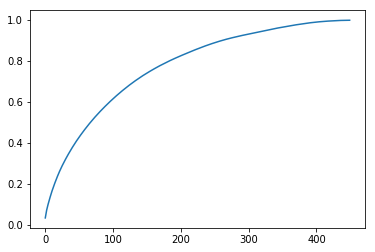

In [69]:
plt.plot(var1)

In [70]:
pca.components_

array([[ 2.80722335e-01,  1.98989845e-01,  1.77931892e-01, ...,
        -5.91732154e-03, -4.67408113e-03,  2.16441697e-02],
       [ 1.28164537e-01,  1.48030686e-01,  1.06576064e-01, ...,
         1.41551304e-03,  1.02386020e-02,  9.51407575e-03],
       [-6.83462296e-02, -1.88419092e-01, -1.44042375e-01, ...,
        -8.76454788e-03, -2.23609064e-02, -3.78735727e-02],
       ...,
       [ 4.83859480e-03,  1.68100127e-02, -5.24456968e-03, ...,
        -1.51586277e-03, -7.73767977e-03, -9.66350191e-03],
       [ 5.15760715e-02,  5.45163656e-03,  4.06941789e-03, ...,
         7.92147329e-05,  1.20465162e-02, -4.46097966e-03],
       [-1.49255197e-02, -7.39824995e-03, -1.33453205e-03, ...,
         1.36953659e-03,  8.36326109e-03, -2.27968318e-03]])

In [71]:
pca = PCA(n_components=450)
# pca.fit(X_train)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [72]:
# Dump components relations with features:
print (pd.DataFrame(pca.components_,columns=X.columns,index = [str(num) for num in range(450)]))

     distance_to_downtown  size_range    shower   parking       dom  latitude  \
0                0.280722    0.198990  0.177932  0.203596 -0.010490  0.301442   
1                0.128165    0.148031  0.106576  0.094284  0.007775  0.112835   
2               -0.068346   -0.188419 -0.144042 -0.078792 -0.038922  0.020326   
3                0.021052   -0.086659 -0.022406  0.116983 -0.012352  0.001582   
4                0.066851   -0.174287 -0.171761 -0.032362 -0.018116  0.152408   
5               -0.014985   -0.017420  0.015073  0.099623 -0.024513 -0.110860   
6                0.030070   -0.023318 -0.038975 -0.086605 -0.037627  0.186338   
7               -0.000108    0.056684  0.087247 -0.007144  0.030023 -0.036164   
8               -0.050215   -0.061751 -0.062581 -0.077579 -0.026549 -0.100508   
9                0.059288    0.003723 -0.063494  0.034432 -0.004252 -0.026002   
10              -0.138272    0.116892  0.119235 -0.021189  0.013659  0.017267   
11              -0.047509   

In [73]:
X_train_pca

array([[-1.50811410e-01, -1.08391563e-01,  1.89323146e-02, ...,
        -4.96516170e-04,  1.17842487e-03, -5.23083542e-04],
       [ 4.85388519e-02, -9.06214614e-02,  4.39541380e-02, ...,
        -2.47214993e-04, -5.30679436e-04,  6.03084338e-04],
       [ 1.17494960e-02,  4.46300531e-02, -5.46021330e-02, ...,
        -2.94561127e-04, -6.55758621e-04,  2.51944883e-04],
       ...,
       [ 4.16576950e-02,  2.39194560e-02, -5.03131441e-02, ...,
         2.74862268e-04, -1.09977550e-04, -2.91441903e-04],
       [-2.80265188e-01, -1.43037525e-01,  5.53251905e-02, ...,
        -9.07626483e-05, -5.17638356e-04,  5.62217493e-04],
       [ 1.78419964e-02, -1.44009403e-02,  7.30543743e-03, ...,
        -1.37803230e-04, -9.89833345e-04,  9.82840269e-04]])

In [74]:
#XGBOOST
import xgboost
xgb2 = xgboost.XGBRegressor(n_estimators=200, learning_rate=0.09, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=6, )
xgb2.fit(X_train_pca, y_train.values)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.09, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.75)

In [75]:
y_pred_xgb = xgb2.predict(X_test_pca)

In [76]:
from sklearn.metrics import mean_squared_error
print(np.sqrt(mean_squared_error(y_test, y_pred_xgb)))

103.68117484839713


In [77]:
# grid search
from sklearn.model_selection import GridSearchCV
import xgboost
from sklearn.metrics import mean_squared_error, make_scorer

pca = PCA(n_components=500)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
# parameters = {'n_estimators' : [150, 200, 250],
#               'learning_rate':[0.01, 0.1],
parameters = {'n_estimators' : [200],
              'min_child_weight': [1, 5, 10],
#               'gamma': [0.5, 1, 1.5, 2.],
#               'subsample': [0.6, 0.8, 1.0],
#               'colsample_bytree': [0.6, 0.8, 1.0],
#               'max_depth': [4, 5, 6, 7]
              }


xgb_cv = xgboost.XGBRegressor(objective='reg:linear')
search2 = GridSearchCV(xgb_cv, parameters, scoring = 'neg_mean_squared_error', cv = 3, verbose = 4)
search2.fit(X_train_pca, y_train)  

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] min_child_weight=1, n_estimators=200 ............................
[CV]  min_child_weight=1, n_estimators=200, score=-10718.730236508112, total=   7.4s
[CV] min_child_weight=1, n_estimators=200 ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.4s remaining:    0.0s


[CV]  min_child_weight=1, n_estimators=200, score=-14792.655327784656, total=   8.4s
[CV] min_child_weight=1, n_estimators=200 ............................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   15.9s remaining:    0.0s


[CV]  min_child_weight=1, n_estimators=200, score=-12226.238720283094, total=   6.0s
[CV] min_child_weight=5, n_estimators=200 ............................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   21.9s remaining:    0.0s


[CV]  min_child_weight=5, n_estimators=200, score=-10885.923716690511, total=   9.1s
[CV] min_child_weight=5, n_estimators=200 ............................
[CV]  min_child_weight=5, n_estimators=200, score=-14520.035707906618, total=   9.5s
[CV] min_child_weight=5, n_estimators=200 ............................
[CV]  min_child_weight=5, n_estimators=200, score=-12189.85424841985, total=   8.5s
[CV] min_child_weight=10, n_estimators=200 ...........................
[CV]  min_child_weight=10, n_estimators=200, score=-11120.91580236498, total=   8.6s
[CV] min_child_weight=10, n_estimators=200 ...........................
[CV]  min_child_weight=10, n_estimators=200, score=-14760.002327579656, total=   9.6s
[CV] min_child_weight=10, n_estimators=200 ...........................
[CV]  min_child_weight=10, n_estimators=200, score=-12549.608240322708, total=   6.3s


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.2min finished


GridSearchCV(cv=3, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [200], 'min_child_weight': [1, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=4)

In [78]:
search.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=5, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [79]:
search.cv_results_

{'mean_fit_time': array([6.43906919, 7.08562342, 6.44334777]),
 'std_fit_time': array([0.07976248, 0.79167062, 0.52056826]),
 'mean_score_time': array([0.00537809, 0.00658727, 0.01021226]),
 'std_score_time': array([0.0008328 , 0.00138176, 0.00663801]),
 'param_min_child_weight': masked_array(data=[1, 5, 10],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[200, 200, 200],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'min_child_weight': 1, 'n_estimators': 200},
  {'min_child_weight': 5, 'n_estimators': 200},
  {'min_child_weight': 10, 'n_estimators': 200}],
 'split0_test_score': array([-7114.488072  , -6986.31976187, -7003.95255398]),
 'split1_test_score': array([-8225.98265531, -8055.56259558, -8081.40957535]),
 'split2_test_score': array([-8622.39746338, -7937.71638049, -8044.40244892]),
 'mean_test_score': array([-7987.62273023, -7659.8